In [1]:
import pickle
import pandas as pd
import numpy as np
from collections import Counter
from torchviz import make_dot

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import random # to undersample trees

with open('wolfCove2m_gnn_823tr50_inflow.pkl','rb') as f:
    data = pickle.load(f)
    labeled_trees = data['labeled_trees_inflow50']
    wolfGraph = data['wolfGraph']
    label_map = data['label_map']
print(label_map)

In [4]:
with open('wolfGraphSU.pkl','rb') as q:
    dataq = pickle.load(q)
    SU_trees = dataq['SU_trees']
    wolfGraph = dataq['wolfGraph']
print("loaded!")

loaded!


In [155]:
# updated with new variables 
def tree_to_pyg(tree_graph, label):
    """ convert networkx tree to pyg data object ..with all new features"""

    # Node features: [ # elev, is_source, is_pit, 
    #                 max_vel, mean_vel, std_vel, mean_erosive, max_erosive, tidal_range,
    #                 total_inflow, mean_inflow, max_inflow]
    node_features = []
    node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(tree_graph.nodes())}

    for node in tree_graph.nodes():
        feat = [
            tree_graph.nodes[node]['elev'],
            # 1.0 if tree_graph.nodes[node].get('is_source',False) else 0.0, # excluding for now
            # 1.0 if tree_graph.nodes[node].get('is_source',False) else 0.0, # excluding for now
            tree_graph.nodes[node].get('max_vel', 0.0),
            tree_graph.nodes[node].get('mean_vel', 0.0),
            tree_graph.nodes[node].get('tidal_range', 0.0),
            tree_graph.nodes[node].get('std_vel', 0.0),
            tree_graph.nodes[node].get('mean_erosive_power', 0.0),
            tree_graph.nodes[node].get('max_erosive_power', 0.0),
            tree_graph.nodes[node].get('total_inflow', 0.0),
            tree_graph.nodes[node].get('mean_inflow', 0.0),
            tree_graph.nodes[node].get('max_inflow', 0.0)
        ]
        node_features.append(feat)

    x = torch.tensor(node_features, dtype=torch.float)

    # edge indices and weights
    edge_index = []
    edge_weight = []

    for u, v in tree_graph.edges():
        edge_index.append([node_mapping[u], node_mapping[v]])
        edge_weight.append(tree_graph.edges[u, v]['weight'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weight, dtype=torch.float).view(-1,1)

    # label
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# pick a tree
selected_pit_ids = list(labeled_trees.keys())
test_tree = labeled_trees[big_pits[0]]

# dummy label (e.g. if > 100 nodes, else 0)
label = 1 if test_tree.number_of_nodes() > 100 else 0

# convert
pyg_data = tree_to_pyg(test_tree, label)

print(pyg_data)
print(f"nodes: {pyg_data.num_nodes}, Edges: {pyg_data.num_edges}")

# 1. practice: create full dataset with labels
pyg_dataset = []
min_nodes = 80
for pit_idx, tree in big_trees.items():
    # binary label: 1 if > min_nodes, else 0
    label = 1 if tree.number_of_nodes() > min_nodes else 0

    pyg_data = tree_to_pyg(tree, label)
    pyg_dataset.append(pyg_data)

print(f"total graphs: {len(pyg_dataset)}")

# update: filter only to bluffs (S, U, H)
bluff_trees = {pit: tree for pit, tree in labeled_trees.items()
               if wolfGraph.nodes[pit]['stability'] in ['S','U','H']}

print(f"bluff trees: {len(bluff_trees)}")

# distribution
tree_labels = [wolfGraph.nodes[pit]['stability'] for pit in bluff_trees.keys()]
print(pd.Series(tree_labels).value_counts())

# undersample: # attempted: try next only S and U

# Keep all U and H
balanced_trees = {pit: tree for pit, tree in labeled_trees.items() 
                  if wolfGraph.nodes[pit]['stability'] in ['U', 'H']}

# Randomly sample 230 S trees
stable_pits = [pit for pit in labeled_trees.keys() 
               if wolfGraph.nodes[pit]['stability'] == 'S']
sampled_stable = random.sample(stable_pits, 230)

for pit in sampled_stable:
    balanced_trees[pit] = labeled_trees[pit]

print(f"Balanced dataset: {len(balanced_trees)} trees")

# 1. real deal: create full dataset with labels
pyg_dataset = []

for pit_idx, tree in labeled_trees.items():
    stability = wolfGraph.nodes[pit_idx]['stability']
    label = label_map[stability]

    pyg_data = tree_to_pyg(tree, label)
    pyg_dataset.append(pyg_data)

print(f"dataset size: {len(pyg_dataset)}")

# 1.a : rebuild dataset:
pyg_dataset = []
for pit_idx, tree in balanced_trees.items():
    stability = wolfGraph.nodes[pit_idx]['stability']
    label = label_map[stability]
    pyg_data = tree_to_pyg(tree, label)
    pyg_dataset.append(pyg_data)

labels = [data.y.item() for data in pyg_dataset]
print(f"\ndataset: {len(pyg_dataset)} trees")
print("distribution: ", Counter(labels))

# attempt 3 : Keep only Stable and Unstable trees
SU_trees = {pit: tree for pit, tree in balanced_trees.items() 
            if wolfGraph.nodes[pit]['stability'] in ['S', 'U']}

print(f"S vs U dataset: {len(SU_trees)} trees")

# Check distribution
su_labels = [wolfGraph.nodes[pit]['stability'] for pit in SU_trees.keys()]
print(pd.Series(su_labels).value_counts())

with open('SU_trees.pkl','wb') as q:
    pickle.dump({'SU_trees':SU_trees},q)
print("saved!")

In [156]:
# attempt 3 : S + U rebuild dataset # hydro data only

label_map = {'S': 0, 'U': 1}  # Binary classification

# Rebuild dataset
pyg_dataset = []
for pit_idx, tree in SU_trees.items():
    stability = wolfGraph.nodes[pit_idx]['stability']
    label = label_map[stability]
    pyg_data = tree_to_pyg(tree, label)
    pyg_dataset.append(pyg_data)

In [157]:
# check label distribution (again!)
labels = [data.y.item() for data in pyg_dataset]
print("/nlabel distribution:")
for name, code in label_map.items():
    count = labels.count(code)
    print(f" {name} ({code}): {count}")

/nlabel distribution:
 S (0): 230
 U (1): 229


# optional: inverse frequency weights

# Stable: 248, Unstable: 143, Historical: 61
class_counts = [248, 143, 61]
total = sum(class_counts)

# Weight inversely proportional to frequency
weights = torch.tensor([total/c for c in class_counts], dtype=torch.float)
weights = weights / weights.sum() * len(class_counts)  # Normalize

print(f"Class weights: S={weights[0]:.2f}, U={weights[1]:.2f}, H={weights[2]:.2f}")

In [158]:
# 2. train/test split (80/20)
train_data, test_data = train_test_split(
    pyg_dataset,
    test_size = 0.2,
    random_state = 42,
    stratify=labels # keep class balance in both splits
)

print(f"train: {len(train_data)}, test: {len(test_data)}")

train: 367, test: 92


In [159]:
# 3. dataloaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

print(f"\nTrain: {len(train_data)}, Test: {len(test_data)}")


Train: 367, Test: 92


In [160]:
# quick check
for batch in train_loader:
    print(f"batch: {batch}")
    print(f"nodes: {batch.num_nodes}, edges: {batch.num_edges}")
    print(f"labels: {batch.y}")
    break
    

batch: DataBatch(x=[1794, 4], edge_index=[2, 1778], edge_attr=[1778, 1], y=[16], batch=[1794], ptr=[17])
nodes: 1794, edges: 1778
labels: tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1])


In [11]:
class TreeGNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim=64, num_classes=3): # 4 classes now! then 3 classes! then 2!
        super(TreeGNN, self).__init__()

        # graph convolution layers
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # classification head
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = torch.nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # graph convolutions with ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # global pooling (aggregate features to graph-level)
        x = global_mean_pool(x, batch)

        # classification layers
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)


        return F.log_softmax(x, dim=1)

In [161]:
# initialize mddel
num_features = 10 # three hydros + elev
model = TreeGNN(num_node_features=num_features, hidden_dim=64, num_classes=2) # 4->3 classes!

In [162]:
print(model)
print(f"total parameters: {sum(p.numel() for p in model.parameters())}")

TreeGNN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
total parameters: 10786


In [163]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [164]:
# reinitialize model every time
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [108]:
# criterion = torch.nn.NLLLoss() # neg. log-likelihood (pairs w. log_softmax)
# opt: use weighted loss
criterion = torch.nn.NLLLoss()
print(f"Criterion using weights: {criterion.weight is not None}")

Criterion using weights: False


In [17]:
# training function
def train(loader):
    model.train()
    total_loss = 0
    correct = 0

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data)
        loss = criterion(out, data.y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()

    return total_loss / len(loader.dataset), correct / len(loader.dataset)

In [18]:
# testing function
def test(loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()

    return correct / len(loader.dataset)

In [165]:
# training loop
num_epochs = 200
train_losses = []
train_accs = []
test_accs = []

print(f"starting training ...\n")

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(train_loader)
    test_acc = test(test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    if epoch % 10 == 0:
        print(f'epoch {epoch:03d}, loss: {train_loss:.4f}, train acc: {train_acc:.4f}, test acc: {test_acc:.4f}')

print("\ntraining complete!")
print(f"final test accuracy: {test_accs[-1]:.4f}")

starting training ...

epoch 010, loss: 0.6732, train acc: 0.5422, test acc: 0.5652
epoch 020, loss: 0.6776, train acc: 0.5422, test acc: 0.5435
epoch 030, loss: 0.6665, train acc: 0.5477, test acc: 0.5870
epoch 040, loss: 0.6586, train acc: 0.5695, test acc: 0.5435
epoch 050, loss: 0.6514, train acc: 0.5504, test acc: 0.5000
epoch 060, loss: 0.6656, train acc: 0.5831, test acc: 0.5435
epoch 070, loss: 0.6474, train acc: 0.5967, test acc: 0.6087
epoch 080, loss: 0.6659, train acc: 0.5395, test acc: 0.5000
epoch 090, loss: 0.6577, train acc: 0.5777, test acc: 0.5435
epoch 100, loss: 0.6452, train acc: 0.6213, test acc: 0.5217
epoch 110, loss: 0.6310, train acc: 0.6349, test acc: 0.5435
epoch 120, loss: 0.6469, train acc: 0.5886, test acc: 0.6087
epoch 130, loss: 0.6523, train acc: 0.6131, test acc: 0.5435
epoch 140, loss: 0.6414, train acc: 0.6213, test acc: 0.5761
epoch 150, loss: 0.6423, train acc: 0.6049, test acc: 0.5109
epoch 160, loss: 0.6186, train acc: 0.6594, test acc: 0.5435
e

best_test_acc = 0
patience = 20
patience_counter = 0
best_model_state = None

for epoch in range(1, 200):
    train_loss, train_acc = train(train_loader)
    test_acc = test(test_loader)
    
    # Check if we improved
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()  # Save best model
        print(f"✓ Epoch {epoch}: New best test acc: {test_acc:.4f}")
    else:
        patience_counter += 1
    
    # Stop if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch}")
        break
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}: Loss: {train_loss:.4f}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')

# Load best model
model.load_state_dict(best_model_state)
print(f"\nBest test accuracy: {best_test_acc:.4f}")

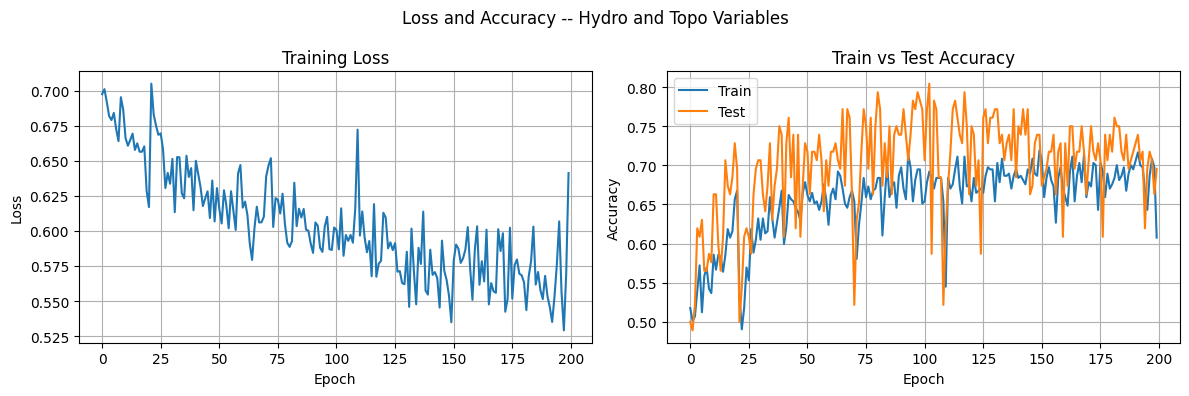

In [137]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(train_losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
#ax1.set_ylim(0.75, 1.25)
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accs, label='Train')
ax2.plot(test_accs, label='Test')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train vs Test Accuracy')
ax2.legend()
#ax2.set_ylim(0.25, 0.75)
ax2.grid(True)

fig.suptitle("Loss and Accuracy -- Hydro and Topo Variables")
plt.tight_layout()
#plt.savefig("fig_459hydroTopoSU69_loss.png")
plt.show()

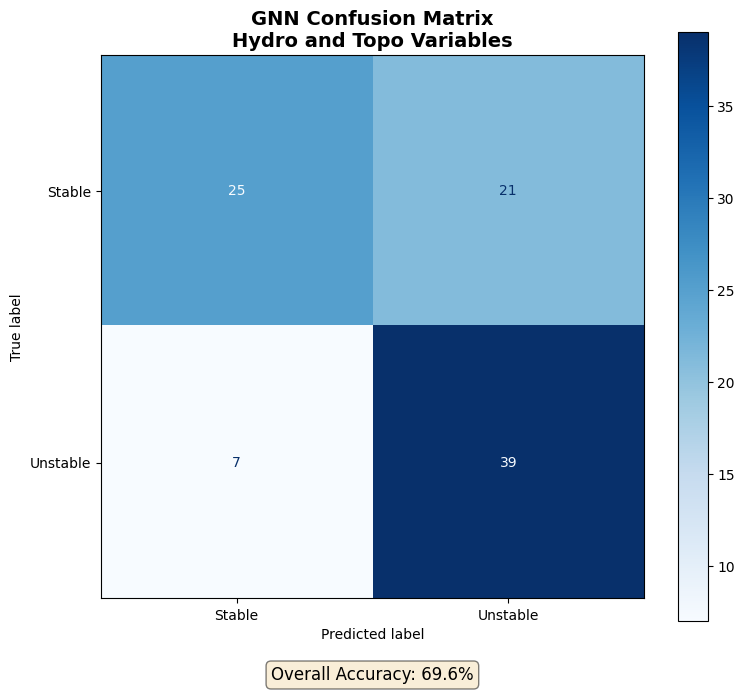


=== Per-Class Performance ===
Stable: 54.3% (25/46)
Unstable: 84.8% (39/46)


In [138]:
# Get predictions on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['Stable', 'Unstable'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('GNN Confusion Matrix\nHydro and Topo Variables', fontsize=14, fontweight='bold')

# Add accuracy to plot
acc = np.trace(cm) / np.sum(cm)
ax.text(0.5, -0.15, f'Overall Accuracy: {acc:.1%}', 
        transform=ax.transAxes, ha='center', fontsize=12,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
#plt.savefig('fig_459hydroTopoSU69_confM.png', dpi=300, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\n=== Per-Class Performance ===")
for i, label in enumerate(['Stable', 'Unstable']):
    class_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    print(f"{label}: {class_acc:.1%} ({cm[i, i]}/{cm[i, :].sum()})")

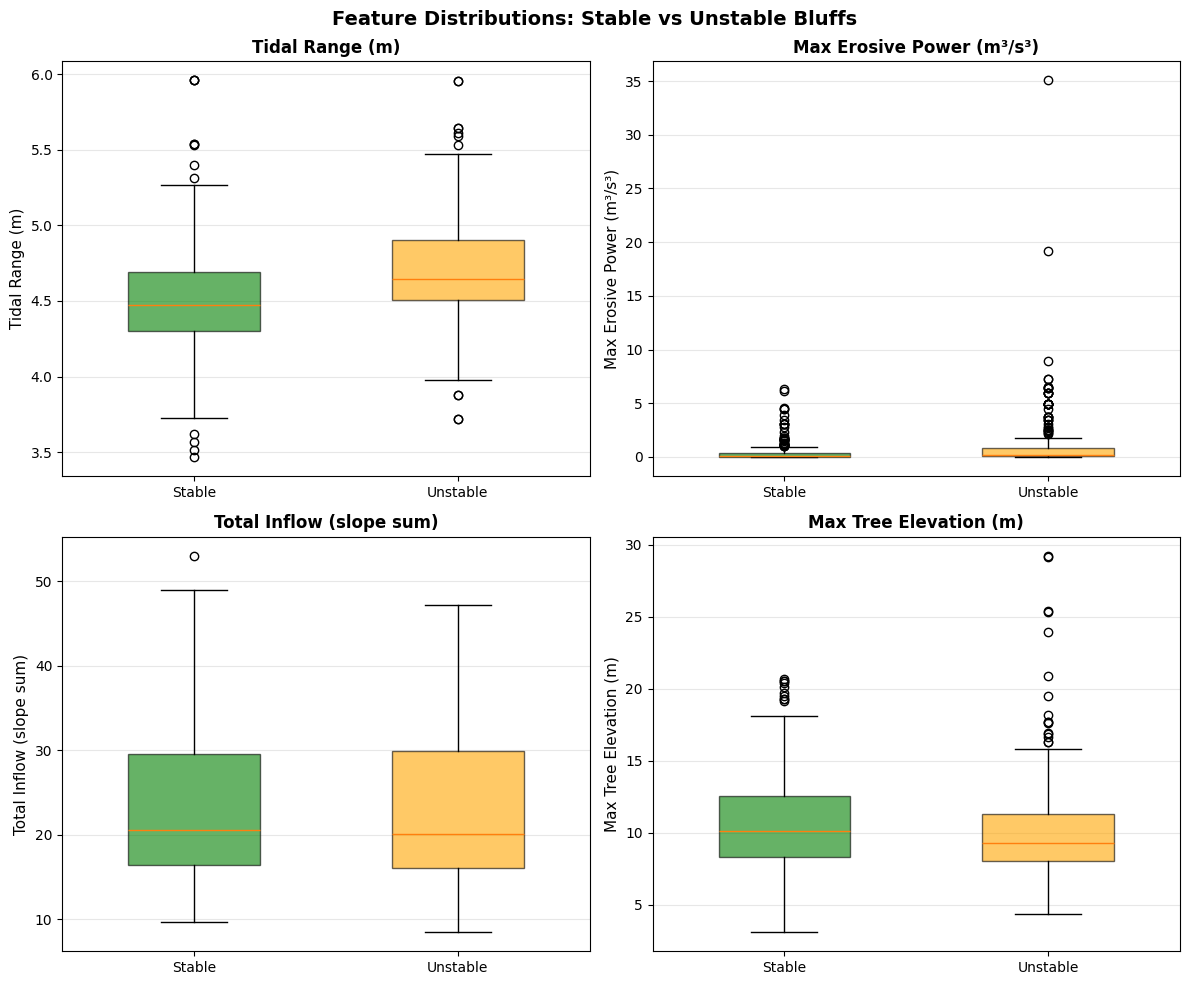

=== FEATURE STATISTICS BY CLASS ===

Tidal Range (m):
  Stable:   4.4956 ± 0.3982
  Unstable: 4.6926 ± 0.3724

Max Erosive Power (m³/s³):
  Stable:   0.4834 ± 0.9844
  Unstable: 1.2444 ± 3.1265

Total Inflow (slope sum):
  Stable:   22.5147 ± 8.5275
  Unstable: 22.3221 ± 8.6718

Max Tree Elevation (m):
  Stable:   10.7313 ± 3.5470
  Unstable: 10.0858 ± 3.8479



In [75]:
# feature importance plotting

# Extract features for S and U trees
features_S = {'tidal_range': [], 'max_erosive': [], 'total_inflow': [], 'max_elev': []}
features_U = {'tidal_range': [], 'max_erosive': [], 'total_inflow': [], 'max_elev': []}

for pit, tree in SU_trees.items():
    stability = wolfGraph.nodes[pit]['stability']
    
    # Get pit-level features
    tidal_range = wolfGraph.nodes[pit]['tidal_range']
    max_erosive = wolfGraph.nodes[pit]['max_erosive_power']
    total_inflow = tree.nodes[pit]['total_inflow']
    
    # Get max elevation across all nodes in tree
    elevs = [tree.nodes[n]['elev'] for n in tree.nodes()]
    max_elev = max(elevs)
    
    if stability == 'S':
        features_S['tidal_range'].append(tidal_range)
        features_S['max_erosive'].append(max_erosive)
        features_S['total_inflow'].append(total_inflow)
        features_S['max_elev'].append(max_elev)
    else:  # U
        features_U['tidal_range'].append(tidal_range)
        features_U['max_erosive'].append(max_erosive)
        features_U['total_inflow'].append(total_inflow)
        features_U['max_elev'].append(max_elev)

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

feature_names = ['tidal_range', 'max_erosive', 'total_inflow', 'max_elev']
titles = ['Tidal Range (m)', 'Max Erosive Power (m³/s³)', 
          'Total Inflow (slope sum)', 'Max Tree Elevation (m)']
colors = ['green', 'orange']

for ax, feat, title in zip(axes, feature_names, titles):
    data = [features_S[feat], features_U[feat]]
    bp = ax.boxplot(data, tick_labels=['Stable', 'Unstable'],
                     patch_artist=True, widths=0.5)
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_title(title, fontweight='bold', fontsize=12)

plt.suptitle('Feature Distributions: Stable vs Unstable Bluffs', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('fig_features_459SU.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("=== FEATURE STATISTICS BY CLASS ===\n")
for feat, title in zip(feature_names, titles):
    print(f"{title}:")
    print(f"  Stable:   {np.mean(features_S[feat]):.4f} ± {np.std(features_S[feat]):.4f}")
    print(f"  Unstable: {np.mean(features_U[feat]):.4f} ± {np.std(features_U[feat]):.4f}")
    print()

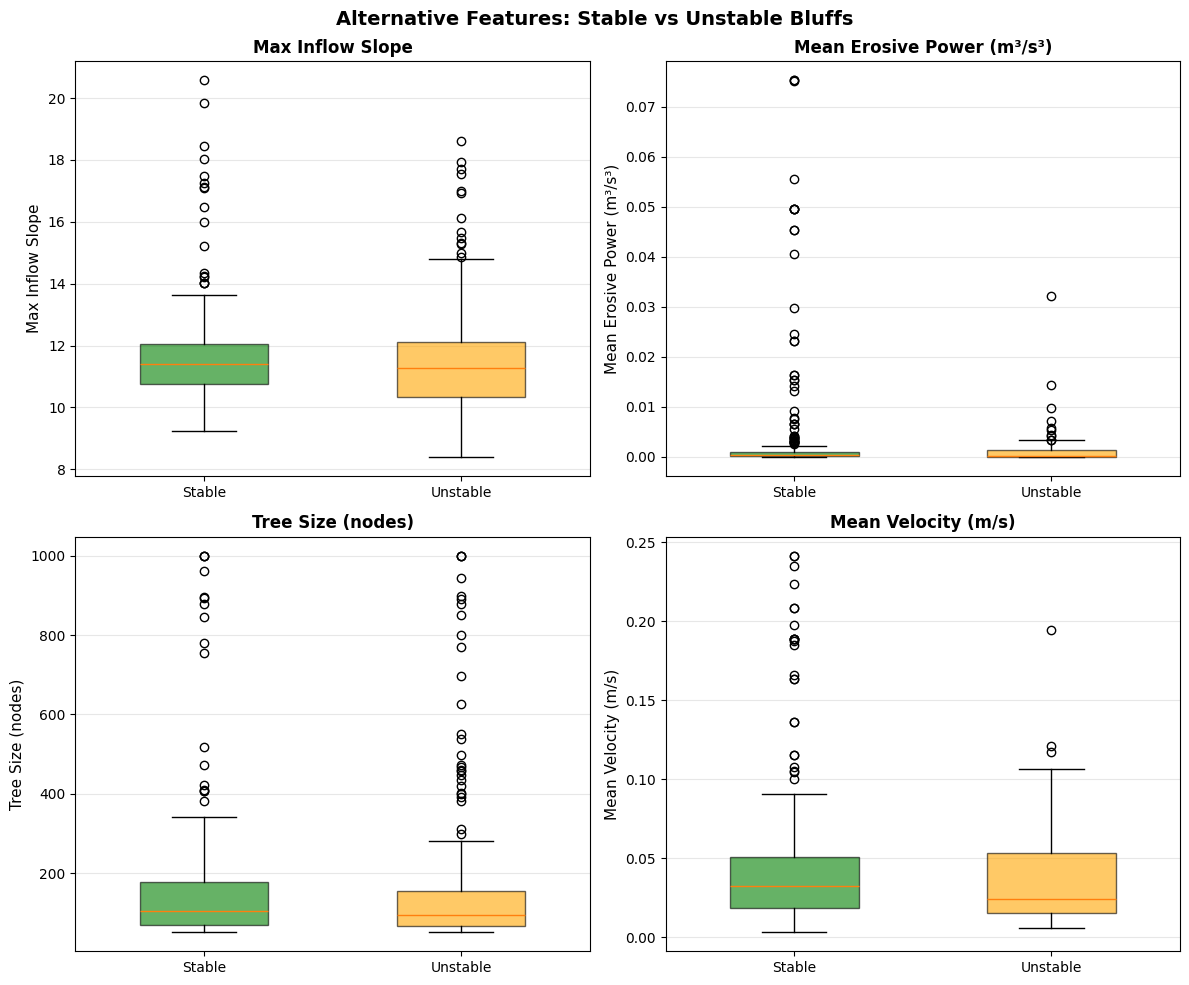

=== ALTERNATIVE FEATURE STATISTICS ===

Max Inflow Slope:
  Stable:   11.6915 ± 1.6898
  Unstable: 11.5072 ± 1.8028

Mean Erosive Power (m³/s³):
  Stable:   0.0042 ± 0.0125
  Unstable: 0.0010 ± 0.0026

Tree Size (nodes):
  Stable:   164.8217 ± 179.7731
  Unstable: 165.4061 ± 193.0067

Mean Velocity (m/s):
  Stable:   0.0474 ± 0.0487
  Unstable: 0.0343 ± 0.0250



In [76]:
# more features!

# Extract features for S and U trees
features_S = {'max_inflow': [], 'mean_erosive': [], 'tree_size': [], 'mean_vel': []}
features_U = {'max_inflow': [], 'mean_erosive': [], 'tree_size': [], 'mean_vel': []}

for pit, tree in SU_trees.items():
    stability = wolfGraph.nodes[pit]['stability']
    
    # Pit-level features
    mean_erosive = wolfGraph.nodes[pit]['mean_erosive_power']
    mean_vel = wolfGraph.nodes[pit]['mean_vel']
    
    # Tree-level features
    max_inflow = tree.nodes[pit]['max_inflow']
    tree_size = tree.number_of_nodes()
    
    if stability == 'S':
        features_S['max_inflow'].append(max_inflow)
        features_S['mean_erosive'].append(mean_erosive)
        features_S['tree_size'].append(tree_size)
        features_S['mean_vel'].append(mean_vel)
    else:  # U
        features_U['max_inflow'].append(max_inflow)
        features_U['mean_erosive'].append(mean_erosive)
        features_U['tree_size'].append(tree_size)
        features_U['mean_vel'].append(mean_vel)

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

feature_names = ['max_inflow', 'mean_erosive', 'tree_size', 'mean_vel']
titles = ['Max Inflow Slope', 'Mean Erosive Power (m³/s³)', 
          'Tree Size (nodes)', 'Mean Velocity (m/s)']
colors = ['green', 'orange']

for ax, feat, title in zip(axes, feature_names, titles):
    data = [features_S[feat], features_U[feat]]
    bp = ax.boxplot(data, tick_labels=['Stable', 'Unstable'],
                     patch_artist=True, widths=0.5)
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(title, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_title(title, fontweight='bold', fontsize=12)

plt.suptitle('Alternative Features: Stable vs Unstable Bluffs', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('fig_altfeats_SU.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("=== ALTERNATIVE FEATURE STATISTICS ===\n")
for feat, title in zip(feature_names, titles):
    print(f"{title}:")
    print(f"  Stable:   {np.mean(features_S[feat]):.4f} ± {np.std(features_S[feat]):.4f}")
    print(f"  Unstable: {np.mean(features_U[feat]):.4f} ± {np.std(features_U[feat]):.4f}")
    print()